In [1]:
import os
import shutil
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing import image as image_prepocessor
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  


c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# data_path = "/home/paperspace/data/dogBreed/"
data_path = r"E:\DogBreed"
im_size = 32
batch_size = 25
epochs = 25
_seed = 1

In [3]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, weights='imagenet')

In [4]:
_training_image_loc = os.path.join(data_path, "train")
_training_label_loc = os.path.join(data_path, "labels.csv")
_testing_image_loc = os.path.join(data_path, "test")
_sample_sub_loc = os.path.join(data_path, "sample_submission.csv")

In [5]:
temp_dir = r".\temp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
bottle_ft_train_path = os.path.join(temp_dir,'btn_ft_train_{}.npy'.format(im_size))
bottle_ft_val_path = os.path.join(temp_dir,'btn_ft_val_{}.npy'.format(im_size))

In [6]:
# def read_img(img_id, training, size):
#     if training == 'train':
#         file_path = _training_image_loc
#     else:
#         file_path = _testing_image_loc
#     img = image_prepocessor.load_img(os.path.join(file_path, '%s.jpg' % img_id), target_size=size)
#     img = image_prepocessor.img_to_array(img)
#     return img

In [7]:
# df = pd.read_csv(_training_label_loc, index_col=0)
# dog_breeds, labels = np.unique(df.values, return_inverse=True)
# no_of_breeds = len(dog_breeds)
# labels = labels.reshape(-1, 1)
# encoder = OneHotEncoder()
# labels = encoder.fit_transform(labels)

In [8]:
def split_images_into_breed(dataframe, new_dir_name):
    sub_path = os.path.join(_training_image_loc, new_dir_name)
    
    if os.path.exists(sub_path):
        print("Folder {} exists.".format(sub_path))
        return sub_path
    
    os.mkdir(sub_path)
        
    for name, group in tqdm(dataframe.groupby("breed")):
        breed_dir = os.path.join(sub_path, name)
        if not os.path.exists(breed_dir):
            os.mkdir(breed_dir)
        for file_name in group["id"]:
            file_path = os.path.join(_training_image_loc, file_name + ".jpg")
            if os.path.exists(file_path):
                shutil.copy(file_path, breed_dir)
    return sub_path

In [9]:
df = pd.read_csv(_training_label_loc)

np.random.seed(seed=_seed)
rnd = np.random.random(df.shape[0])
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8

traing_df = df[train_idx]
validation_df = df[valid_idx]
train_data_loc = split_images_into_breed(traing_df, "train")
val_data_loc = split_images_into_breed(validation_df, "valid")

Folder E:\DogBreed\train\train exists.
Folder E:\DogBreed\train\valid exists.


In [13]:
data_generator = ImageDataGenerator(rescale=1. / 255)
if not os.path.exists(bottle_ft_train_path):
    train_generator = data_generator.flow_from_directory(train_data_loc,
                                                         target_size=(im_size, im_size), 
                                                         batch_size=batch_size,
                                                         class_mode=None,
                                                         shuffle=False)
    num_of_training_samples = len(train_generator.filenames)
    num_classes = len(train_generator.class_indices)
    steps = int(math.ceil(num_of_training_samples / batch_size))  

    bottleneck_features_train = model.predict_generator(train_generator, steps)
    np.save(bottle_ft_train_path, bottleneck_features_train)
else:
    print("Skipping saving of train data.")

Skipping saving of train data.


In [14]:
if not os.path.exists(bottle_ft_val_path):
    val_generator = data_generator.flow_from_directory(val_data_loc,
                                                       target_size=(im_size, im_size), 
                                                       batch_size=batch_size,
                                                       class_mode=None,
                                                       shuffle=False)
    num_of_val_samples = len(val_generator.filenames)
    steps = int(math.ceil(num_of_val_samples / batch_size))  

    bottleneck_features_val = model.predict_generator(val_generator)
    np.save(bottle_ft_val_path, bottleneck_features_val)  
else:
    print("Skipping saving of validation data.")

Skipping saving of validation data.


In [15]:
# Generator with images and Labels
train_generator = data_generator.flow_from_directory(train_data_loc,
                                                     target_size=(im_size, im_size), 
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=False)
num_of_training_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)

train_data = np.load(bottle_ft_train_path)
train_labels = train_generator.classes.reshape(-1, 1)
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(train_labels)

Found 8221 images belonging to 120 classes.


In [16]:
val_generator = data_generator.flow_from_directory(val_data_loc,
                                                   target_size=(im_size, im_size), 
                                                   batch_size=batch_size,
                                                   class_mode=None,
                                                   shuffle=False)
num_of_val_samples = len(val_generator.filenames)
validation_data = np.load(bottle_ft_val_path)  
validation_labels = val_generator.classes.reshape(-1, 1)
encoder = OneHotEncoder()
validation_labels = encoder.fit_transform(validation_labels)

Found 2001 images belonging to 120 classes.


In [15]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
             metrics=["accuracy"])
history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,
                   validation_data=(validation_data, validation_labels))


Train on 8221 samples, validate on 2001 samples
Epoch 1/25
8221/8221 [==============================] - ETA: 6:28 - loss: 4.8304 - acc: 0.040 - ETA: 1:40 - loss: 4.8835 - acc: 0.010 - ETA: 37s - loss: 4.8638 - acc: 0.014 - ETA: 21s - loss: 4.8743 - acc: 0.01 - ETA: 15s - loss: 4.8622 - acc: 0.01 - ETA: 12s - loss: 4.8542 - acc: 0.01 - ETA: 10s - loss: 4.8476 - acc: 0.01 - ETA: 8s - loss: 4.8466 - acc: 0.0096 - ETA: 7s - loss: 4.8449 - acc: 0.009 - ETA: 6s - loss: 4.8380 - acc: 0.008 - ETA: 6s - loss: 4.8339 - acc: 0.009 - ETA: 5s - loss: 4.8328 - acc: 0.008 - ETA: 4s - loss: 4.8245 - acc: 0.009 - ETA: 4s - loss: 4.8233 - acc: 0.009 - ETA: 4s - loss: 4.8243 - acc: 0.009 - ETA: 3s - loss: 4.8216 - acc: 0.009 - ETA: 3s - loss: 4.8186 - acc: 0.010 - ETA: 3s - loss: 4.8159 - acc: 0.010 - ETA: 3s - loss: 4.8134 - acc: 0.010 - ETA: 2s - loss: 4.8123 - acc: 0.010 - ETA: 2s - loss: 4.8112 - acc: 0.010 - ETA: 2s - loss: 4.8085 - acc: 0.010 - ETA: 2s - loss: 4.8068 - acc: 0.010 - ETA: 2s - loss: 

8221/8221 [==============================] - ETA: 2s - loss: 4.2768 - acc: 0.0000e+0 - ETA: 3s - loss: 4.3070 - acc: 0.0343    - ETA: 2s - loss: 4.2964 - acc: 0.055 - ETA: 2s - loss: 4.2458 - acc: 0.066 - ETA: 2s - loss: 4.2764 - acc: 0.061 - ETA: 2s - loss: 4.2899 - acc: 0.061 - ETA: 2s - loss: 4.2729 - acc: 0.059 - ETA: 2s - loss: 4.2925 - acc: 0.061 - ETA: 2s - loss: 4.2803 - acc: 0.065 - ETA: 2s - loss: 4.2858 - acc: 0.067 - ETA: 2s - loss: 4.2847 - acc: 0.065 - ETA: 1s - loss: 4.2872 - acc: 0.064 - ETA: 1s - loss: 4.2909 - acc: 0.064 - ETA: 1s - loss: 4.2909 - acc: 0.064 - ETA: 1s - loss: 4.2922 - acc: 0.065 - ETA: 1s - loss: 4.3039 - acc: 0.063 - ETA: 1s - loss: 4.3074 - acc: 0.063 - ETA: 1s - loss: 4.3015 - acc: 0.063 - ETA: 1s - loss: 4.2987 - acc: 0.064 - ETA: 1s - loss: 4.2953 - acc: 0.064 - ETA: 1s - loss: 4.2921 - acc: 0.064 - ETA: 1s - loss: 4.2957 - acc: 0.064 - ETA: 1s - loss: 4.3025 - acc: 0.064 - ETA: 1s - loss: 4.3039 - acc: 0.063 - ETA: 1s - loss: 4.3068 - acc: 0.063

8221/8221 [==============================] - ETA: 2s - loss: 3.6634 - acc: 0.120 - ETA: 2s - loss: 3.8352 - acc: 0.108 - ETA: 2s - loss: 3.9636 - acc: 0.102 - ETA: 2s - loss: 3.9920 - acc: 0.114 - ETA: 2s - loss: 4.0094 - acc: 0.100 - ETA: 2s - loss: 4.0235 - acc: 0.101 - ETA: 2s - loss: 4.0260 - acc: 0.094 - ETA: 2s - loss: 4.0351 - acc: 0.093 - ETA: 2s - loss: 4.0405 - acc: 0.096 - ETA: 2s - loss: 4.0485 - acc: 0.094 - ETA: 2s - loss: 4.0411 - acc: 0.093 - ETA: 1s - loss: 4.0362 - acc: 0.093 - ETA: 1s - loss: 4.0432 - acc: 0.091 - ETA: 1s - loss: 4.0385 - acc: 0.090 - ETA: 1s - loss: 4.0470 - acc: 0.089 - ETA: 1s - loss: 4.0471 - acc: 0.089 - ETA: 1s - loss: 4.0542 - acc: 0.089 - ETA: 1s - loss: 4.0561 - acc: 0.088 - ETA: 1s - loss: 4.0556 - acc: 0.088 - ETA: 1s - loss: 4.0573 - acc: 0.087 - ETA: 1s - loss: 4.0685 - acc: 0.089 - ETA: 1s - loss: 4.0718 - acc: 0.088 - ETA: 1s - loss: 4.0736 - acc: 0.088 - ETA: 1s - loss: 4.0761 - acc: 0.087 - ETA: 1s - loss: 4.0832 - acc: 0.088 - ETA: 

8221/8221 [==============================] - ETA: 2s - loss: 4.1341 - acc: 0.120 - ETA: 2s - loss: 3.8798 - acc: 0.128 - ETA: 2s - loss: 3.8560 - acc: 0.136 - ETA: 2s - loss: 3.8502 - acc: 0.149 - ETA: 2s - loss: 3.8503 - acc: 0.142 - ETA: 2s - loss: 3.8861 - acc: 0.138 - ETA: 2s - loss: 3.8915 - acc: 0.132 - ETA: 2s - loss: 3.8867 - acc: 0.128 - ETA: 2s - loss: 3.9007 - acc: 0.126 - ETA: 2s - loss: 3.9034 - acc: 0.123 - ETA: 2s - loss: 3.9065 - acc: 0.123 - ETA: 1s - loss: 3.9087 - acc: 0.121 - ETA: 1s - loss: 3.9027 - acc: 0.121 - ETA: 1s - loss: 3.9032 - acc: 0.122 - ETA: 1s - loss: 3.9080 - acc: 0.121 - ETA: 1s - loss: 3.9004 - acc: 0.121 - ETA: 1s - loss: 3.8899 - acc: 0.121 - ETA: 1s - loss: 3.8949 - acc: 0.123 - ETA: 1s - loss: 3.9047 - acc: 0.122 - ETA: 1s - loss: 3.9011 - acc: 0.120 - ETA: 1s - loss: 3.9047 - acc: 0.121 - ETA: 1s - loss: 3.9113 - acc: 0.119 - ETA: 1s - loss: 3.9204 - acc: 0.119 - ETA: 1s - loss: 3.9229 - acc: 0.118 - ETA: 1s - loss: 3.9202 - acc: 0.118 - ETA: 

8221/8221 [==============================] - ETA: 1s - loss: 1.1921e-07 - acc: 0.040 - ETA: 2s - loss: 1.1921e-07 - acc: 0.008 - ETA: 2s - loss: 1.1921e-07 - acc: 0.011 - ETA: 2s - loss: 1.1921e-07 - acc: 0.011 - ETA: 2s - loss: 1.1921e-07 - acc: 0.010 - ETA: 2s - loss: 1.1921e-07 - acc: 0.012 - ETA: 2s - loss: 1.1921e-07 - acc: 0.011 - ETA: 1s - loss: 1.1921e-07 - acc: 0.010 - ETA: 1s - loss: 1.1921e-07 - acc: 0.010 - ETA: 1s - loss: 1.1921e-07 - acc: 0.009 - ETA: 1s - loss: 1.1921e-07 - acc: 0.009 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - acc: 0.009 - ETA: 1s - loss: 1.1921e-07 - acc: 0.009 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - acc: 0.009 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - acc: 0.008 - ETA: 1s - loss: 1.1921e-07 - ac

8221/8221 [==============================] - ETA: 2s - loss: 1.1921e-07 - acc: 0.040 - ETA: 2s - loss: 1.1921e-07 - acc: 0.008 - ETA: 2s - loss: 1.1921e-07 - acc: 0.004 - ETA: 2s - loss: 1.1921e-07 - acc: 0.003 - ETA: 2s - loss: 1.1921e-07 - acc: 0.005 - ETA: 2s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - ac

Epoch 25/25
8221/8221 [==============================] - ETA: 2s - loss: 1.1921e-07 - acc: 0.0000e+0 - ETA: 2s - loss: 1.1921e-07 - acc: 0.0000e+0 - ETA: 2s - loss: 1.1921e-07 - acc: 0.0024    - ETA: 2s - loss: 1.1921e-07 - acc: 0.001 - ETA: 1s - loss: 1.1921e-07 - acc: 0.003 - ETA: 1s - loss: 1.1921e-07 - acc: 0.005 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.005 - ETA: 1s - loss: 1.1921e-07 - acc: 0.005 - ETA: 1s - loss: 1.1921e-07 - acc: 0.005 - ETA: 1s - loss: 1.1921e-07 - acc: 0.005 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.006 - ETA: 1s - loss: 1.1921e-07 - acc: 0.007 - ETA: 1s

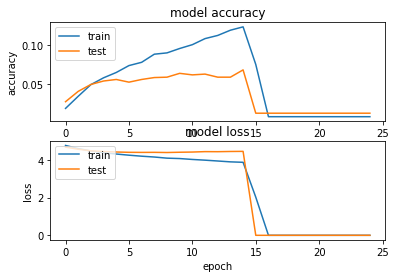

In [16]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [6]:
list_of_imgs = np.array([read_img(img_id, "train", (im_size, im_size)) for img_id in tqdm(df.index.values)])

100%|███████████████████████████████████████████████████████████████████████████| 10222/10222 [00:36<00:00, 280.66it/s]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(list_of_imgs, labels, test_size=0.2)
print(y_train.shape)

9199
(9199, 120)


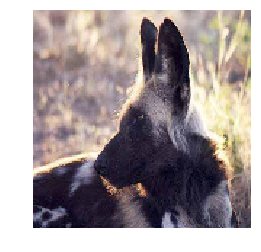

In [17]:
plt.axis('off')
plt.imshow(X_train[1].astype(np.uint8))